## 3.1 Create a Jupyter Notebook and Initialize Variables

In [5]:
## 3.1
from sagemaker import get_execution_role

# retrieve the name of the IAM role that the notebook is running under
role = get_execution_role()
bucket = 'rh-sagemaker-20181024'

print("role: {}".format(role))
print("bucket: {}".format(bucket))

role: arn:aws:iam::191216456264:role/service-role/AmazonSageMaker-ExecutionRole-20181030T052942
bucket: rh-sagemaker-20181024


## 3.2 Download, Explore, and Transform the Training Data

* Download MNIST dataset
* Transform from `numpy.array` to `RecordIO` format
    * [RecordIO Data Format](http://mxnet.incubator.apache.org/architecture/note_data_loading.html#data-format)

### 3.2.1 Download MNIST Dataset

In [5]:
## 3.2.1
import pickle, gzip, numpy, urllib.request, json

# download the dataset to the notebook's local storage
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")

# deserialize the contents into train, validation, and test sets
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

### 3.2.2 Explore the Training Dataset

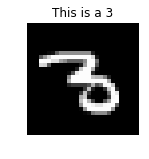

In [6]:
## 3.2.2
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

def show_digit(img, caption='', subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1,1)
    imgr = img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

### 3.2.3 Transform the Training Dataset and Upload to S3

* transform from numpy.array to RecordIO protobuf format
* more efficient for the algorithms provided by SageMaker
* 2 approaches available:
  * high-level SageMaker Python libraries
  * lower level boto3 Python libraries

In [7]:
## 3.2.3 -- LOW LEVEL handling
from sagemaker.amazon.common import write_numpy_to_dense_tensor
import io
import boto3

def save_numpy_as_dense_tensor(train_set, bucket, data_key):
    ## convert the training data into the format required by the
    ## SageMaker K-Means algorithm
    buf = io.BytesIO()
    write_numpy_to_dense_tensor(buf, train_set[0], train_set[1])
    buf.seek(0)

    boto3.resource('s3').Bucket(bucket).Object(data_key).upload_fileobj(buf)    

In [8]:
%%time

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)

print('training data will be uploaded to: {}'.format(data_location))

save_numpy_as_dense_tensor(train_set, bucket, data_key)

training data will be uploaded to: s3://rh-sagemaker-20181024/kmeans_lowlevel_example/data
CPU times: user 8.57 s, sys: 252 ms, total: 8.82 s
Wall time: 9.59 s


## 3.3 Train a Model

* Call `CreateTrainingJob`, providing
  * training image ECR path
  * training data S3 path
  * resources configuration to use

### 3.3.1 Choose the Training Algorithm

### 3.3.2 Create a Training Job

* high-level Python api
    * create instance of training algorithm
    * call `fit` method, passing configuration details
    
    
* role: name of the IAM role under which SageMaker runs while performing training
* output_path: S3 location for storing generated output artifacts
* train_instance_count: # of instances to use for training
* train_instance_type: type of instances to use for training
* k: the number of clusters to create
* data_location: location of training data

In [9]:
%%time

from sagemaker import KMeans

data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_highlevel_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(role=role, train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,data_location=data_location)

kmeans.fit(kmeans.record_set(train_set[0]))

training data will be uploaded to: s3://rh-sagemaker-20181024/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://rh-sagemaker-20181024/kmeans_highlevel_example/output


INFO:sagemaker:Creating training-job with name: kmeans-2018-10-30-11-08-55-639


2018-10-30 11:08:55 Starting - Starting the training job...
2018-10-30 11:08:56 Starting - Launching requested ML instances.........
2018-10-30 11:10:29 Starting - Preparing the instances for training......
2018-10-30 11:11:41 Downloading - Downloading input data...
2018-10-30 11:12:22 Training - Training image download completed. Training in progress.
2018-10-30 11:12:22 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[10/30/2018 11:12:17 INFO 140408755816256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor


2018-10-30 11:12:27 Completed - Training job completed
Billable seconds: 94
CPU times: user 8.01 s, sys: 417 ms, total: 8.43 s
Wall time: 4min 22s


using the low-level python api:

In [11]:
%%time
import boto3
from time import gmtime, strftime

job_name = 'kmeans-lowlevel-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Training job", job_name)

images = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com/kmeans:latest',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com/kmeans:latest',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com/kmeans:latest',
    'ap-northeast-1': '351501993468.dkr.ecr.ap-northeast-1.amazonaws.com/kmeans:latest',
    'ap-northeast-2': '835164637446.dkr.ecr.ap-northeast-2.amazonaws.com/kmeans:latest',
    'ap-southeast-2': '712309505854.dkr.ecr.ap-southeast-2.amazonaws.com/kmeans:latest',
    'eu-central-1': '438346466558.dkr.ecr.eu-central-1.amazonaws.com/kmeans:latest',
    'eu-west-1': '664544806723.dkr.ecr.eu-west-1.amazonaws.com/kmeans:latest'
}

image = images[boto3.Session().region_name]

data_key = 'kmeans_lowlevel_example/data'
data_location = 's3://{}/{}'.format(bucket, data_key)

output_location = 's3://{}/kmeans_lowlevel_example/output'.format(bucket)
print('training artifacts will be uploaded to: {}'.format(output_location))

create_training_params = {
    "AlgorithmSpecification": {
        "TrainingImage": image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": output_location
    },
    "ResourceConfig": {
        "InstanceCount": 2,
        "InstanceType": "ml.c4.8xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    
    "HyperParameters": {
        "k": "10",
        "feature_dim": "784",
        "mini_batch_size": "500"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": data_location,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }
    ]
}

sagemaker = boto3.client('sagemaker')
sagemaker.create_training_job(**create_training_params)

status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)

try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)

    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))

        raise Exception('Training job failed')

Training job kmeans-lowlevel-2018-10-30-11-31-19
training artifacts will be uploaded to: s3://rh-sagemaker-20181024/kmeans_lowlevel_example/output
InProgress
Training job ended with status: Completed
CPU times: user 52.3 ms, sys: 4.63 ms, total: 56.9 ms
Wall time: 4min


## 3.4 Deploy the Model to Amazon SageMaker

2 Options

* Persistent endpoint to provide one prediction at a time
* Use batch transform to generate predictions for an entire data set

### 3.4.1 Deploy the Model to Amazon SageMaker Hosting Services

3 Steps

1. Create a model in SageMaker
1. Create an endpoint configuration
1. Create an endpoint

The high level api performs all of these via a call to the `deploy` method.

The low level api provides methods corresponding to each step above.

In [6]:
## if needed, reload the previously trained model
from sagemaker import KMeansModel
model_data = "s3://rh-sagemaker-20181024/kmeans_highlevel_example/output/kmeans-2018-10-30-11-08-55-639/output/model.tar.gz"

kmeans = KMeansModel(model_data=model_data, role=role)

In [9]:
%%time

## high level api
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: kmeans-2018-10-30-12-14-57-662
INFO:sagemaker:Creating endpoint with name kmeans-2018-10-30-12-14-57-662


----------------------------------------------------------------!CPU times: user 282 ms, sys: 18.1 ms, total: 300 ms
Wall time: 5min 24s


In [ ]:
%%time

## LOW LEVEL API

## create model

import boto3
from time import gmtime, strftime

model_name = job_name
print(model_name)

info = sagemaker.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

create_model_response = sagemaker.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container
)

print(create_model_response['ModelArn'])

In [ ]:
## create endpoint configuration
from time import gmtime, strftime

endpoint_config_name = 'KMeansEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)

create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'
    }]
)

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

In [ ]:
%%time
## create endpoint

import time

endpoint_name = 'KMeansEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)

create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)
    
    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Create endpoint failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed.')

### 3.4.2 Deploy the Model to Amazon SageMaker Batch Transform

* via console, OR
* high level api, OR
* low level api

In [ ]:
## high level api:

import boto3
import sagemaker
import json

input_key = 'kmeans_batch_example/input/valid-data.csv'
input_location = 's3://{}/{}'.format(bucket, input_key)
output_location = 's3://{}/kmeans_batch_example/output'.format(bucket)

# convert validation set numpy array to CSV and upload to S3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
s3_client.upload_file('valid-data.csv', bucket, input_key)

# initialize the transformer object
transformer = sagemaker.transformer.Transformer(
    base_transform_job_name='Batch-Transform',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path=output_location
)

# start a transform job
transformer.transform(input_location, content_type='text/csv', split_type='Line')

# wait for the job to complete
transformer.wait()

# fetch the validation result
s3_client.download_file(bucket, 'kmeans_batch_example/output/valid-data.csv.out', 'valid-result')

with open('valid-result') as f:
    results = f.readlines()
    
print("Sample transform result: {}".format(results[0]))

In [ ]:
## low level api

import boto3
import sagemaker
import json

from urllib.parse import urlparse
from time import gmtime, strftime

batch_job_name = 'Batch-Transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
input_location = 's3://{}/kmeans_batch_example/input'.format(bucket)
output_location = 's3://{}/kmeans_batch_example/output'.format(bucket)

# convert the validation set numpy array to a csv file and upload to S3
numpy.savetxt('valid-data.csv', valid_set[0], delimiter=',', fmt='%g')
s3_client = boto3.client('s3')
input_key = "{}/valid_data.csv".format(urlparse(input_location).path.lstrip('/'))
s3_client.upload_file('valid-data.csv', bucket, input_key)

# create a transform job
sm = boto3.client('sagemaker')
request = {
    "TransformJobName": batch_job_name,
    "ModelName": model_name,
    "MaxConcurrentTransforms": 4,
    "MaxPayloadInMB": 6,
    "BatchStrategy": "MultiRecord",
    "TransformOutput": {
        "S3OutputPath": output_location
    },
    "TransformInput": {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                
                "S3Uri": input_location 
            }
        },
        "ContentType": "text/csv",
        "SplitType": "Line",
        "CompressionType": "None"
    },
    "TransformResources": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1
    }
}

sm.create_transform_job(**request)
print("Created Transform job with name: ", batch_job_name)

### Wait until job completion
while(True):
    response = sm.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if  status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    print("Transform job is still in status: " + status)    
    time.sleep(30)
    
### Fetch transform output
output_key = "{}/valid_data.csv.out".format(urlparse(output_location).path.lstrip('/'))
s3_client.download_file(bucket, output_key, 'valid-result')
with open('valid-result') as f:
    results = f.readlines()   
    print("Sample transform result: {}".format(results[0]))

## view details of transform job
response = sm.describe_transform_jbo(TransformJobName=job_name)

## list transform jobs
import boto3
from time import gmtime, strftime
request = {
    "StatusEquals": "Completed",
    "SortBy": "CreationTime",
    "SortOrder": "Descending",
    "MaxResults": 20,
}

response = sm.list_transform_jobs(**request)